# 航空公司客户价值分析  
数据：air_data  
模型：LRFMC  
算法：K-Means  

**学习目标：**
 1. 熟悉客户价值分析的步骤和流程
 2. 了解RFM模型的基本原理
 3. 掌握K-Means算法的基本原理和使用方法
 4. 从分类的客户信息中提炼客户价值，以制定相应的营销策略  
 
**任务描述：**
1. 借助航空公司客户数据，对客户进行分类。
2. 对不同的客户类别进行特征分析，比较不同类别客户的客户价值。
3. 对不同价值的客户类别提供个性化服务，制定相应的营销策略。

# 1 客户价值分析

## 1.1 认识客户价值分析
客户营销战略倡导者Jay & Adam Curry从国外数百家公司进行了客户营销实施的经验中提炼了如下经验!
+ 公司收入的80%来自顶端的20%的客户。
+ 20%的客户其利润率100%。
+ 90%以上的收入来自现有客户。
+ 大部分的营销预算经常被用在非现有客户上。
+ 5%至30%的客户在客户金字塔中具有升级潜力。
+ 客户金字塔中客户升级2%，意味着销售收入增加10%，利润增加50%。  
这些经验也许并不完全准确，但它揭示了新时代客户分化的趋势，也说明了对客户价值分析的迫切性和必要性。

## 1.2 客户价值分析的步骤和流程

![title](./imgChap7/Fig7_1.png)

4个步骤：
1. 抽取航空公司20120401至20140331间的数据
2. 对数据进行预处理：数据清洗，特征构建和数据标准化等操作
3. 基于RFM模型，使用KMeans算法进行客户分群
4. 针对模型结果得到的不同客户群，分析客户价值，制定对应的定制化营销方案

# 2 预处理客户数据

## 2.1 数据探索

In [1]:
import numpy as np
import pandas as pd
airSource = pd.read_csv("./dataChap7/air_data.csv",sep=',',encoding="gb18030")
print("airSource.shape:",airSource.shape)
#探索分析S1：数据描述
explore = airSource.describe(include='all').T
print(explore.head(5))

airSource.shape: (62988, 44)
                   count unique        top   freq     mean       std  min  \
MEMBER_NO          62988    NaN        NaN    NaN  31494.5   18183.2    1   
FFP_DATE           62988   3068  2011/1/13    184      NaN       NaN  NaN   
FIRST_FLIGHT_DATE  62988   3406  2013/2/16     96      NaN       NaN  NaN   
GENDER             62985      2          男  48134      NaN       NaN  NaN   
FFP_TIER           62988    NaN        NaN    NaN  4.10216  0.373856    4   

                       25%      50%      75%    max  
MEMBER_NO          15747.8  31494.5  47241.2  62988  
FFP_DATE               NaN      NaN      NaN    NaN  
FIRST_FLIGHT_DATE      NaN      NaN      NaN    NaN  
GENDER                 NaN      NaN      NaN    NaN  
FFP_TIER                 4        4        4      6  


In [2]:
##探索分析S2：关键信息描述
#关键信息：空值(缺失值)信息，极值等
explore['null'] = len(airSource) - explore['count']   #为explore添加"null"列
print(explore[['null','min','max']].head(5))

                  null  min    max
MEMBER_NO            0    1  62988
FFP_DATE             0  NaN    NaN
FIRST_FLIGHT_DATE    0  NaN    NaN
GENDER               3  NaN    NaN
FFP_TIER             0    4      6


In [3]:
##探索分析S3：直接统计空值(缺失值)信息
nullDetail = airSource.isnull().sum()    #对缺失值进行统计
print("nullDetail:",nullDetail)

nullDetail: MEMBER_NO                     0
FFP_DATE                      0
FIRST_FLIGHT_DATE             0
GENDER                        3
FFP_TIER                      0
WORK_CITY                  2269
WORK_PROVINCE              3248
WORK_COUNTRY                 26
AGE                         420
LOAD_TIME                     0
FLIGHT_COUNT                  0
BP_SUM                        0
EP_SUM_YR_1                   0
EP_SUM_YR_2                   0
SUM_YR_1                    551
SUM_YR_2                    138
SEG_KM_SUM                    0
WEIGHTED_SEG_KM               0
LAST_FLIGHT_DATE              0
AVG_FLIGHT_COUNT              0
AVG_BP_SUM                    0
BEGIN_TO_FIRST                0
LAST_TO_END                   0
AVG_INTERVAL                  0
MAX_INTERVAL                  0
ADD_POINTS_SUM_YR_1           0
ADD_POINTS_SUM_YR_2           0
EXCHANGE_COUNT                0
avg_discount                  0
P1Y_Flight_Count              0
L1Y_Flight_Count            

**通过explore获知：**
**原始数据中包含40多个特征的6万条记录(62988, 44)，利用这些特征做些什么呢？我们又该从哪些角度出发呢？  
首先需要了解特征的意义：客户基本信息；乘机信息；积分信息等**     
票价收入：SUM_YR_1，SUM_YR_2；平均折扣：avg_discount；飞行里程：SEG_KM_SUM；总积分：Points_Sum 

**通过概览数据我们发现航空公司客户原始数据存在少量的缺失值和异常值，需要清洗后才能用于分析**  
1. 存在票价为空值的记录，可能是客户不存在乘机记录造成的。   
2. 存在票价值为0，但总飞行公里数大于0的记录，可能是客户积分兑换造成。  
3. 存在折扣率值为0，但总飞行公里数大于0的记录，可能是客户乘坐0折机票造成
由于原始数据量大，这类数据所占比例较小，对于问题影响不大，因此对其进行丢弃处理。

**处理方法：**  
1. 丢弃票价为空的记录,即保留票价不为空记录：data['SUM_YR_1'].notnull(),data['SUM_YR_2'].notnull()
2. 丢弃票价为0，总飞行公里数大于0的记录;丢弃平均折扣率为0，总飞行公里数大于0的记录  即保留票价非零、平均折扣非零且飞行里程大于零的记录.  
(data["SUM_YR_1"]!=0 | data["SUM_YR_2"]!=0) & data[avg_discount]!=0 & data[SEG_KM_SUM]>0

## 2.2 数据预处理
**任务步骤**
1. 数据清洗：处理数据缺失值和异常值
2. 结合RFM模型筛选特征 -> 构建LRFMC模型
3. 标准化LRFMC模型数据

### 2.2.1 数据清洗：缺失值/异常值处理

In [4]:
#数据清洗
print("airSource.shape:",airSource.shape)

#1.剔除缺失值
#丢弃票价为null的记录
notNullInd1 = airSource["SUM_YR_1"].notnull()
notNullInd2 = airSource["SUM_YR_2"].notnull()
notNullInd = notNullInd1 & notNullInd2
airNotNull = airSource.loc[notNullInd,:]  #airNotNull = airSource[notNullInd]
#print("type(airNotNull)",type(airNotNull))
print("airNotNull.shape:",airNotNull.shape)
#print("airNotNull.head(3):\n",airNotNull.iloc[:3,:5])

#2.剔除异常值
#丢弃票价为0，总飞行里程>0的记录
#丢弃平均折扣率为0,总飞行里程>0的记录
#与(&) ; 或(|) ； 取反(~)
index1 = (airNotNull["SUM_YR_1"] == 0) & (airNotNull["SUM_YR_2"] == 0)  #括号必须有
index2 = airNotNull["avg_discount"] == 0 
index3 = airNotNull["SEG_KM_SUM"] > 0 
index = ~((index1 & index3)|(index2 & index3))
airDataPre = airNotNull[index]         #airDataPre = airNotNull.loc[index,:]
print("airDataPre.shape:",airDataPre.shape)
#print("airDataPre.tail(3):\n",airDataPre.iloc[-3:,:5])
airDataPre.to_csv("./dataChap7/airDataPre.csv",sep=',',index=False,encoding="gb18030")  #保存airData数据到文件airDataPre

airSource.shape: (62988, 44)
airNotNull.shape: (62299, 44)
airDataPre.shape: (62044, 44)


### 2.2.2 选择特征并构建LRFMC模型

1. RFM模型介绍  
识别客户价值应用最广泛的模型是RFM模型。  

● R（Recency）:时近效应，指最近一次消费时间与截止时间的间隔。间隔越短，对提供的商品或是服务最有可能感兴趣。  
● F（Frequency）：频次效应，指顾客在某段时间内所消费的次数。频率越高的顾客其忠诚度也就越高，顾客价值也就越大。  
● M（Monetary）：能力效应，指顾客在某段时间内所消费的金额。金额越大表明其消费能力越大，这就是所谓“20%的顾客贡献了80%的销售额”的二八法则。

2. RFM模型结果解读  
RFM模型包括三个特征，使用三维坐标系进行展示，如图所示。  
X轴表示Recency，Y轴表示Frequency，Z轴表示Monetary，每个轴一般会分成5级表示程度，1为最小，5为最大。

![title](./imgChap7/Fig7_2.png)

3. 传统RFM模型在航空行业的缺陷与优化  
● 在RFM模型中，消费金额是一段时间内客户购买产品金额的总和，在航空业，其实同样消费金额的旅客对航空公司的价值是不同的，例如：购买长航线低仓位的与短航线高仓位的旅客相比，对公司而言，显然后者价值更高。因此M特征需要优化，这里采用飞行总里程M和客户的相应的折扣系数C两个特征来代替消费金额。M相同的情况下，C值越大价值越高  
● 会员入会时间长短在一定程度上影响客户的价值，因此增加客户关系长度L特征，L越大价值越高

4. 航空客户价值分析的LRFMC模型  
将客户关系长度L，消费时间间隔R，消费频率F，飞行里程M和折扣系数的平均值C作为航空公司识别客户价值的关键特征（如表所示），记为LRFMC模型。

模型 | L | R | F | M | C | 
-:|-:|-:|-:|-:|-:|
LRFMC|会员入会时间距观测窗口结束的月数|客户最近一次飞行距观测窗口结束的月数|客户在观测窗口内乘坐飞机的次数|客户在观测窗口内累计的飞行里程|客户在观测窗口期内乘坐舱位对应的折扣系统平均值|

由于原始数据中并没直接给出LRFMC模型的5个特征，需要从原始数据的提取出这5个特征：  
(1)  L = 观测窗口结束时间 - 入会时间(单位：天数)：  L = LOAD_TIME - FFP_DATE  
(2)  R = 最后一次乘机时间至观测窗口末端时长(单位：天数)：  R = LAST_TO_END  
(3)  F = 观测窗口期内的飞行次数(单位：次)：  F = FLIGHT_COUNT  
(4)  M = 观测窗口期内的飞行里程(单位：千米)： M = SEG_KM_SUM  
(5)  C = 观测窗口期内的平均折扣率(单位：无)： C = avg_discount  

In [5]:

#选取并构建LRFMC模型
feature =  airDataPre.columns
print("feature:\n",feature)
# s1：选择特征：使用字典形式选择特征数据
tmp = {
    'L':pd.to_datetime(airDataPre['LOAD_TIME']) - pd.to_datetime(airDataPre['FFP_DATE']),
    'R':airDataPre['LAST_TO_END'],
    'F':airDataPre['FLIGHT_COUNT'],
    'M':airDataPre['SEG_KM_SUM'],
    'C':airDataPre['avg_discount']
} 
# s2：合并特征：使用选择特征构建新数据集
airLRFMC = pd.DataFrame(data=tmp,columns=['L','R','F','M','C'])
print("airLRFMC.head(3):\n",airLRFMC.head(3))

# s3：格式化特征：特征L格式化
#将timedelta64 -> int32格式
import numpy as np
print("airLRFMC['L'][:3]:\n",airLRFMC['L'][:3])
dayTime = np.timedelta64(1,'D')
#如果要变成月的话: monthTime = np.timedelta64(30,'D')
#print("type(dayTime):",type(dayTime))
airLRFMC["L"]  = (airLRFMC["L"]/dayTime).astype(int)
print("airLRFMCC['L'][:3]:\n",airLRFMC['L'][:3])

#s4:保存变换后的DataFrame数据 ->csv
print("airLRFMC.head(3):\n",airLRFMC.head(3))
airLRFMC.to_csv("./dataChap7/airLRFMC.csv",sep=",",index=False,encoding="gb18030")  #index=False 不要行名
print("Write airLRFMC.csv done,check ./dataChap7")

feature:
 Index(['MEMBER_NO', 'FFP_DATE', 'FIRST_FLIGHT_DATE', 'GENDER', 'FFP_TIER',
       'WORK_CITY', 'WORK_PROVINCE', 'WORK_COUNTRY', 'AGE', 'LOAD_TIME',
       'FLIGHT_COUNT', 'BP_SUM', 'EP_SUM_YR_1', 'EP_SUM_YR_2', 'SUM_YR_1',
       'SUM_YR_2', 'SEG_KM_SUM', 'WEIGHTED_SEG_KM', 'LAST_FLIGHT_DATE',
       'AVG_FLIGHT_COUNT', 'AVG_BP_SUM', 'BEGIN_TO_FIRST', 'LAST_TO_END',
       'AVG_INTERVAL', 'MAX_INTERVAL', 'ADD_POINTS_SUM_YR_1',
       'ADD_POINTS_SUM_YR_2', 'EXCHANGE_COUNT', 'avg_discount',
       'P1Y_Flight_Count', 'L1Y_Flight_Count', 'P1Y_BP_SUM', 'L1Y_BP_SUM',
       'EP_SUM', 'ADD_Point_SUM', 'Eli_Add_Point_Sum', 'L1Y_ELi_Add_Points',
       'Points_Sum', 'L1Y_Points_Sum', 'Ration_L1Y_Flight_Count',
       'Ration_P1Y_Flight_Count', 'Ration_P1Y_BPS', 'Ration_L1Y_BPS',
       'Point_NotFlight'],
      dtype='object')
airLRFMC.head(3):
           L   R    F       M         C
0 2706 days   1  210  580717  0.961639
1 2597 days   7  140  293678  1.252314
2 2615 days  11  135  

## 2.3 标准化LRFMC模型特征

对构建后的数据进行探索分析，可知五个特征的取值范围差异较大，  
为了消除数量级带来的影响，要做标准化处理，这里使用标准差标准化

In [6]:
#数据探索
exploreLRFMC = airLRFMC.describe()
print("exploreLRFMC:\n",exploreLRFMC)

exploreLRFMC:
                  L             R             F              M             C
count  62044.00000  62044.000000  62044.000000   62044.000000  62044.000000
mean    1488.69109    172.532703     11.971359   17321.694749      0.722180
std      847.88092    181.526164     14.110619   21052.728111      0.184833
min      365.00000      1.000000      2.000000     368.000000      0.136017
25%      735.00000     29.000000      3.000000    4874.000000      0.613085
50%     1278.00000    105.000000      7.000000   10200.000000      0.712162
75%     2182.00000    260.000000     15.000000   21522.500000      0.809293
max     3437.00000    731.000000    213.000000  580717.000000      1.500000


特征名称 | L | R | F | M | C | 
-:|-:|-:|-:|-:|-:|
min|365.0|1.0|2.0 |368.0| 0.13|
max|3437.0|731.0|213.0|580717.0 |1.5|

**标准差标准化方法1:  编写标准差标准化函数，如下：**  

In [7]:
#采用z-score标准化
def Zscore(data):
    data = (data-data.mean())/data.std()
    data.columns = ["Z"+i for i in data.columns]
    return data
    
airZscore = Zscore(airLRFMC)
print("type(airZscore):",type(airZscore))
print("airZscore.head(3):\n",airZscore.head(3))

type(airZscore): <class 'pandas.core.frame.DataFrame'>
airZscore.head(3):
          ZL        ZR         ZF         ZM        ZC
0  1.435707 -0.944948  14.034016  26.761154  1.295540
1  1.307152 -0.911894   9.073213  13.126864  2.868176
2  1.328381 -0.889859   8.718869  12.653481  2.880950


**标准差标准化方法2: from sklearn.preprocessing import StandardScaler，如下：**  

In [ ]:
#数据标准化(标准差标准化)

print("type(airLRFMC):",type(airLRFMC))
print("airLRFMC.head(3):\n",airLRFMC.head(3))
#采用标准差标准化
from sklearn.preprocessing import StandardScaler
#标准化s1： 建立规则  fit()
Scaler = StandardScaler().fit(airLRFMC)
#标准化s2： 应用规则 transform()
dataScaler = Scaler.transform(airLRFMC)
# 由于fit()和transform()的应用对象一样，所以以上两个步骤也可以合成一个
# 即：dataScaler = StandardScaler().fit_transform(airLRFMC)
print("type(dataScaler):",type(dataScaler))
print("dataScaler[:3,:]\n",dataScaler[:3,:])

#将标准化的数据保存至文件(了解就可以了)
import numpy as np
np.save("./dataChap7/dataScaler.npy",dataScaler)   # 保存为numpy的npy文件
np.savez("./dataChap7/dataScaler.npz",dataScaler)   # 保存为numpy的npz文件   #注意npy与npz文件的读取不同之处
np.savetxt("./dataChap7/dataScaler.csv",dataScaler,delimiter=",")
np.savetxt("./dataChap7/dataScalerHead.csv",dataScaler,delimiter=",",header="ZL,ZR,ZF,ZM,ZC")

#推荐使用pandas的DataFrame数据处理方式
airLRFMCscaler = pd.DataFrame(dataScaler,columns=['ZL','ZR','ZF','ZM','ZC'])
print("airLRFMCscaler.head(3):\n",airLRFMCscaler.head(3))
airLRFMCscaler.to_csv("./dataChap7/airLRFMCscaler.csv",sep=",",index=False,encoding="gb18030")  #index=False 不要行名

**分析以上两种标准化方式的结果，可发现：**   
**虽然具体的数据一样，但是所得的数据类型不同**  
**方法1是：<class 'pandas.core.frame.DataFrame'>**  
**方法2是：<class 'numpy.ndarray'>，当然，可使用pd.DataFrame()转换成DF** 

# 3 K-Means聚类

K-Means聚类算法简单易行，适用于大中型数据量。  
**本节任务：**  
(1) 了解K-Means算法基本原理  
(2) 使用K-Means算法对航空客户数据聚类分群  
(3) 应用模型聚类结果定制营销方案

## 3.1 K-Means聚类算法的基本原理

### 3.1.1  KMeans算法原理及步骤

K-Means聚类是一种基于质心的划分方法，输入聚类个数k，应用于n个数据对象，可输出满足**误差平方和最小**的k个聚类。  
**算法步骤：**  
(1) 从n个样本中随机选取k个对象作为初始的聚类中心；  
(2) 分别计算每个样本到各个聚类质心的距离，并将样本分配到距离最近的那个聚类中心类别中；  
(3) 所有样本分配完成后，再次计算k个聚类的中心；  
(4) 与前一次计算得到的k个聚类中心比较，如果聚类中心发生变化，转(2)，否则转(5)；  
(5) 当质心不发生变化时停止并输出聚类结果。

**算法优缺点：**  
■优点：原理简单，易于实现，计算复杂度较小。  
■缺点：  
▲ 缺点1：过分依赖初始值选择，一旦初始值选的不好，可能无法的到有效的聚类结果；  
▲ 缺点2：需要预先给定k值，这是最困难的一点；    
▲ 缺点3：对离群点非常敏感，容易使质心偏移。

### 3.1.2 Kmeans研究的数据类型

K-Means聚类算法是在**数值类型**数据的基础上进行研究，然而数据分析的样本复杂多样，因此要求不仅能够对特征为数值类型的数据进行分析，还要对不同特征做不同变换以适应数据类型的变化，满足算法的要求。

### 3.1.3 KMeans函数语法及参数

sklearn.cluster模块中提供了KMeans函数来构建K-Means聚类模型   
**基本语法：**   
KMeans(n_clusters=8, init='k-means++', n_init=10, max_iter=300, tol=0.0001, precompute_distances='auto', verbose=0, random_state=None, copy_x=True, n_jobs=None, algorithm='auto')

In [ ]:
#使用K-Means算法对航空客户信息进行聚类分析
import numpy as np
from sklearn.cluster import KMeans
help(KMeans)

|参数名称及默认值 | 说明 | 
|:-:|:-:|
n_clusters=8|接收int，表示分类簇的数量，很重要的参数，需要给定|
init='k-means++'|接收string，表示初始值选择策略。'k-means++'表示选择的初始均值向量之间距离较远，效果较好； 'random'表示随机选取；还可以用 ndarray自定义初始均值向量，形状为(n_clusters, n_features)|
n_init=10|接收int，表示算法运行的次数|
max_iter=300|接收int，表示做大迭代次数|
tol=0.0001|接收float，表示算法收敛的阈值|
precompute_distances='auto' |接收boolean或auto，表示是否提前计算好样本之间的距离；若为auto，当 n_samples * n_clusters>12 million不会提前计算，因为会占用太大内存为|
verbose=0|接收int，0表示不输出日志；1表示每个一段时间输出一次日志；数值越大输出日志越频繁|
random_state=None|接收int，表随机生成器的种子|
copy_x=True|当precompute_distances=True时，首先要做的事对数据进行中心处理。如果copy_x为True(默认值)，则不修改原始数据。如果为False，则在修改原始数据。|
n_jobs=None|接收int，表示计算使用的CPU数量，None表示1个，-1表示使用全部|
algorithm='auto'|选择K-means使用的具体算法，可取"auto", "full" or "elkan"。“auto”会自动选择“elkan”用于密集数据，“full”用于稀疏数据。“full”是经典的EM-style算法 ；“elkan”的效率更高，但目前不支持稀疏数据|

#### 3.1.3.1 聚类分析S1: 读取数据   
**读文件"./dataChap7/airLRFMCscaler.csv"**

In [10]:
#航空客户信息价值分析K-Means聚类
import pandas as pd

from sklearn.cluster import KMeans
#聚类分析S1: 读取数据
data = pd.read_csv("./dataChap7/airLRFMCscaler.csv",sep=",",encoding="gb18030")
print("data.head(3):\n",data.head(3))

data.head(3):
          ZL        ZR         ZF         ZM        ZC
0  1.435719 -0.944955  14.034129  26.761370  1.295551
1  1.307162 -0.911902   9.073286  13.126970  2.868199
2  1.328392 -0.889866   8.718940  12.653583  2.880973


#### 3.1.3.2 聚类分析S2: 选取k(簇个数)

首先选取聚类的类别个数，就是对原始数据聚类事先不知道分成几类合适，那怎么确定呢？   
◆**inertias：**是K-Means模型对象的一个属性，它作为没有真实分类结果标签下的非监督式评估指标。表示样本到最近的聚类中心的距离总和。值越小越好，越小表示样本在类间的分布越集中。   
◆使用**肘方法**确定簇的最佳数量，通过画出不同k值对应的聚类偏差图，可以清楚看出：聚类偏差变化减缓的k值点，就是最佳分类k值。  

In [11]:
#导入库
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

#导入数据
x= data
#肘方法看k值
d=[]
for i in range(1,11):   #k取值1~10，做kmeans聚类，看不同k值对应的簇内误差平方和
    km = KMeans(n_clusters=i,init='k-means++',n_init=10,max_iter=300,random_state=0)
    km.fit(x)
    d.append(km.inertia_)  #inertia簇内误差平方和
    
plt.plot(range(1,11),d,marker='o')
plt.xlabel('number of clusters')
plt.ylabel('distortions')
plt.savefig("./temp/kSelect.png")
plt.show()

print(d)

<Figure size 640x480 with 1 Axes>

[310220.0, 229348.68172113062, 184346.80551170406, 151013.16351026887, 133362.30113928826, 118069.04717571355, 107635.5432921045, 100707.93259517461, 93874.07925308862, 88331.06574470545]


#### 3.1.3.3 聚类分析S3: 构建模型 训练模型

In [12]:
from sklearn.cluster import KMeans
#由肘图可确定 k=5
k = 5

#聚类分析S3: 构建模型 并 训练模型
kmeansModel = KMeans(n_clusters=k,n_jobs=4,random_state=110).fit(data)

### 3.1.4 K-Means模型属性

**K-Means模型构建并训练完后，我们需要获取模型最终的分类信息，包括聚类中心、样本的类别标签、不同类别的样本数等**

属性名称 |说明 | 
:-:|:-:|
cluster_centers_|返回ndaray，表示分类簇的均值向量，即聚类中心点|
labels_|返回ndaray，表示样本的所属的簇的标记，即样本类别标签|
.inertia_|返回ndaray，表示每个样本距离他们各自最近簇中心之和|


#### 3.1.4.1 获取聚类属性

In [13]:
#输出保存模型属性：聚类类别，聚类个数，聚类中心等
import pandas as pd
labels = kmeansModel.labels_        #所有样本的类别标签
clusters = set(labels)              #类别种类
count = pd.Series(labels).value_counts()#类别中的样本数（会自动排序）
center = kmeansModel.cluster_centers_   #所有特征的聚类中心 
inertia = kmeansModel.inertia_          #所有类别的样本中心距

print("labels:",labels,"  len(labels):",len(labels))  #类别标签
print("clusters:",clusters)    #类别
print("count:\n",count)        #每类中的样本数统计
print("center:\n",center)      #每个特征的聚类中心


labels: [4 4 4 ... 0 1 1]   len(labels): 62044
clusters: {0, 1, 2, 3, 4}
count:
 0    24659
2    15740
1    12125
4     5336
3     4184
dtype: int64
center:
 [[-0.7002121  -0.41489162 -0.16114387 -0.16095881 -0.25513359]
 [-0.31368082  1.68627205 -0.57402062 -0.53682451 -0.1733275 ]
 [ 1.16067608 -0.37722423 -0.08691922 -0.09484481 -0.15590586]
 [ 0.05184321 -0.00266815 -0.22680493 -0.23125594  2.19136467]
 [ 0.48333235 -0.7993897   2.48322162  2.42474345  0.30863251]]


#### 3.1.4.2 整理聚类属性并保存至CSV

**说明：模型为kmeansModel,数据为DF类型的data = airLRFMCscaler.csv，见3.1.3.1**

**S1.简单输出聚类中心与分类样本数目**

In [14]:
#模型为kmeansModel,数据为DF类型的data = airLRFMCscaler.csv，见3.1.3.1

#S1.简单输出聚类中心与分类样本数目
myCenter = pd.DataFrame(kmeansModel.cluster_centers_)    #聚类中心
myCount = pd.Series(kmeansModel.labels_).value_counts()  #统计每个类别中样本数目
myClass = pd.Series(['Class'+ str(i) for i in range(5)]) #k=5
dataResult  = pd.concat([myClass,myCount,myCenter],axis=1)
columnsCenter = [col+"_Center" for col in data.columns]
dataResult.columns = ["Category","SampleSize"] + columnsCenter    #新加样本数量和聚类类别系列名

print("dataResult.shape:",dataResult.shape)
print(dataResult)
file = "./dataChap7/airClusterResult.csv"
dataResult.to_csv(file,sep=",",index=False)   #写入文件


dataResult.shape: (5, 7)
  Category  SampleSize  ZL_Center  ZR_Center  ZF_Center  ZM_Center  ZC_Center
0   Class0       24659  -0.700212  -0.414892  -0.161144  -0.160959  -0.255134
1   Class1       12125  -0.313681   1.686272  -0.574021  -0.536825  -0.173328
2   Class2       15740   1.160676  -0.377224  -0.086919  -0.094845  -0.155906
3   Class3        4184   0.051843  -0.002668  -0.226805  -0.231256   2.191365
4   Class4        5336   0.483332  -0.799390   2.483222   2.424743   0.308633


**S2.详细输出原始数据及其类别,即在airLRFMCscaler.csv基础上添加类别列后，写入airLRFMCscalerCluster.csv中**

In [15]:
#S2.详细输出原始数据及其类别,即在airLRFMCscaler.csv基础上添加类别列后，写入新csv中
print("data.shape:",data.shape)
print("data.head(3):\n",data.head(3))   #dataZscore为Z标准化后的DF数据集，见2.3
classLabels = pd.Series(kmeansModel.labels_,index=data.index) #每个样本对应类别
dataCategory = pd.concat([data,classLabels],axis=1)
dataCategory.columns = list(data.columns) + ["Category"]
print("dataCategory.shape:",dataCategory.shape)
print("dataCategory.head(3):\n",dataCategory.head(3))
file = "./dataChap7/airLRFMCscalerCluster.csv"
dataCategory.to_csv(file,sep=",",index=False)   #写入文件

data.shape: (62044, 5)
data.head(3):
          ZL        ZR         ZF         ZM        ZC
0  1.435719 -0.944955  14.034129  26.761370  1.295551
1  1.307162 -0.911902   9.073286  13.126970  2.868199
2  1.328392 -0.889866   8.718940  12.653583  2.880973
dataCategory.shape: (62044, 6)
dataCategory.head(3):
          ZL        ZR         ZF         ZM        ZC  Category
0  1.435719 -0.944955  14.034129  26.761370  1.295551         4
1  1.307162 -0.911902   9.073286  13.126970  2.868199         4
2  1.328392 -0.889866   8.718940  12.653583  2.880973         4


**S3.为数据集airDataPre添加类标签 -> airDataWithClass.csv**

In [16]:
import pandas as pd

print("airDataPre.shape:",airDataPre.shape)
labels = kmeansModel.labels_   #获取聚类结果的类别标签
print("len(labels):",len(labels))
classLabels = pd.Series(labels,index=airDataPre.index) #创建类别系列
airDataWithClass = pd.concat([airDataPre,classLabels],axis=1)  #将类别系列合并到airDataPre中
airDataWithClass.columns = list(airDataPre.columns) + ["Category"] #添加系列名称
print("airDataWithClass.shape:",airDataWithClass.shape)
file = "./dataChap7/airDataWithClass.csv"
airDataWithClass.to_csv(file,sep=",",index=False,encoding='gb18030')   #写入文件

airDataPre.shape: (62044, 44)
len(labels): 62044
airDataWithClass.shape: (62044, 45)


**S4.在DF数据集(airDataWithClass)中选取用户特征及分类特征组成用户分类数据集并写入customerCluster.csv中**

In [17]:
#在DF数据集airDataWithClass中，选择如下用户特征：
#'MEMBER_NO','GENDER','AGE', 'WORK_CITY', 'FFP_DATE','ClusterCategory',
#并将信息保存到customerCluster.csv中
#print("airDataWithClass.columns:\n",airDataWithClass.columns)

tmp = {
    'MemberNo':airDataWithClass['MEMBER_NO'],
    'Gender':airDataWithClass['GENDER'],
    'Age':airDataWithClass['AGE'],
    'WorkCity':airDataWithClass['WORK_CITY'],
    'FFPdate':airDataWithClass['FFP_DATE'], 
    'Category': airDataWithClass['Category']
}
customerCluster = pd.DataFrame(data=tmp,columns=['MemberNo','Gender','Age','WorkCity','FFPdate','Category'])
print("customerCluster.head(3):\n",customerCluster.head(3))
customerCluster.to_csv("./temp/customerCluster.csv",sep=",",encoding='gb18030')

customerCluster.head(3):
    MemberNo Gender   Age WorkCity    FFPdate  Category
0     54993      男  31.0        .  2006/11/2         4
1     28065      男  42.0      NaN  2007/2/19         4
2     55106      男  40.0        .   2007/2/1         4


#### 3.1.4.3 按类别分解airDataWithClass.csv -> 多个类别的csv中

**把DF数据集(airDataWithClass)根据'Category'特征分解成几个类别数据集并保存成csv**

In [18]:
#print(airDataWithClass.head(3))
#以类0为例
dataCluster0 = airDataWithClass.loc[airDataWithClass["Category"]==0]
print(dataCluster0.shape)

clusters = set(airDataWithClass["Category"])  #获取类别
print(clusters)

#使用循环实现
for c in clusters:
    dataCluster = airDataWithClass.loc[airDataWithClass["Category"]==c]
    file = "./temp/airDataCategory" + str(c) + ".csv"
    dataCluster.to_csv(file,sep=",",encoding='gb18030')
print("airDataCategory files done,check ./temp/")


(24659, 45)
{0, 1, 2, 3, 4}
airDataCategory files done,check ./temp/


## 3.2 分析聚类结果

### 3.2.1 类的特征分布
聚类结果dataResult已经保存在"./dataChap7/airClusterResult.csv"中，见3.1.4.2，S1

In [19]:
print(dataResult)

  Category  SampleSize  ZL_Center  ZR_Center  ZF_Center  ZM_Center  ZC_Center
0   Class0       24659  -0.700212  -0.414892  -0.161144  -0.160959  -0.255134
1   Class1       12125  -0.313681   1.686272  -0.574021  -0.536825  -0.173328
2   Class2       15740   1.160676  -0.377224  -0.086919  -0.094845  -0.155906
3   Class3        4184   0.051843  -0.002668  -0.226805  -0.231256   2.191365
4   Class4        5336   0.483332  -0.799390   2.483222   2.424743   0.308633


根据聚类中心绘制客户群特征分布雷达图

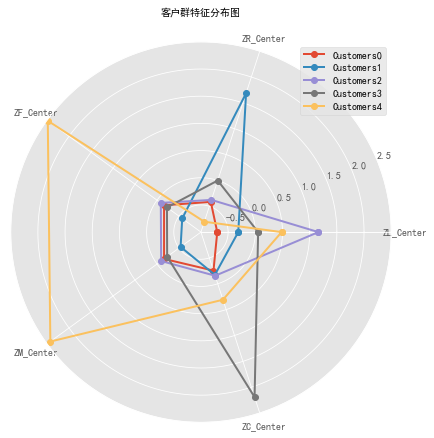

In [20]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
#s1:设置中文显示及绘图风格
matplotlib.rcParams['font.family'] =  'SimHei'
matplotlib.rcParams['font.sans-serif'] = ['SimHei'] 
matplotlib.rcParams['axes.unicode_minus'] = False  # 设置正常显示负号
plt.style.use("ggplot")

#s2:数据与标签
dataCenter = dataResult[[ 'ZL_Center', 'ZR_Center', 'ZF_Center', 'ZM_Center', 'ZC_Center']]
# features = list(dataResult.columns)
# print("features:",features)
# labels = features[2:]
# print("labels:",labels)
# labels = np.array(labels)
labels = np.array([ 'ZL_Center', 'ZR_Center', 'ZF_Center', 'ZM_Center', 'ZC_Center'])
dataLenth = len(labels)

N = len(dataCenter)   #绘制图形个数


#s3:绘制雷达图
#s3_1: 设置角度，用于平分圆面
angels = np.linspace(0,2*np.pi,dataLenth,endpoint=False)
#s3_2: 封闭数据
data = pd.concat([dataCenter,dataCenter.iloc[:,0]],axis=1)  #即ZC后面要接ZL
#s3_3: 封闭图形
angles = np.concatenate((angels,[angels[0]]))
#s3_4: 设置画布与极坐标系
fig = plt.figure(figsize=(7,7))
ax = fig.add_subplot(111,polar=True) #111代表在一个画布上绘制多个图形
#s3_5: 绘制线条
for i in range(N):
    ax.plot(angles,data.iloc[i,:],'o-',linewidth=2,label='Customers'+str(i))
    
#ax.fill(angles,data,facecolor='r',alpha=0.25)  # 填充

#s3_6: 添加特征标签
ax.set_thetagrids(angles*180/np.pi,labels)
#s3_7: 添加标题
ax.set_title("客户群特征分布图",va='bottom',fontproperties='simHei') #使用黑体
#s3_8: 设置雷达图范围
L = dataCenter.min
R = dataCenter.max
ax.set_rlim(-1,2.5)
#s3_9: 添加网线
ax.grid(True)
#s3_10: 添加图例
plt.legend()
#s4:先保存后显示
plt.savefig('./imgChap7/custormerDistribution.png')
plt.show()



### 3.2.2 客户价值分析

客户价值排名,根据值的大小顺序，输出相应数量的*号，表示价值大小，星号越多，价值越高

In [21]:
print("dataResult:\n",dataResult)

# 函数功能是将serie中的值，按值的升序/降序转成相应数量的*号
def value2Star(serie,reverse=False):
    starList=[]
    sortedData = sorted(serie,reverse=reverse)
    
    for item in serie:
        index = sortedData.index(item)
        stars =  "*"*(index+1)
        starList.append(stars)       
    return starList 

# serie1 = [3,2,5,1,7]
# print(value2Star(serie1))
# print(value2Star(serie1,reverse=True))

value2starDF = dataResult.copy()  #先拷贝一个DF框架

value2starDF = pd.concat([dataResult['Category'],dataResult["SampleSize"]],axis=1)  #保留两个系列
dataCenter = dataResult[[ 'ZL_Center', 'ZR_Center', 'ZF_Center', 'ZM_Center', 'ZC_Center']]
columns = dataCenter.columns

for col in columns:
    serie = dataCenter[col]
    if col == 'ZR_Center':            #说明：ZR采用降序，原因是其值越大，代表长时间没有光顾，价值越低
        reverse = True
    else:
        reverse = False
    stars = value2Star(serie,reverse=reverse)   #调用value2star转换函数
    starsSerie = pd.Series(stars,index=dataCenter.index,name=col)
    value2starDF = pd.concat([value2starDF,starsSerie],axis=1)
    
print("value2starDF:\n",value2starDF)


dataResult:
   Category  SampleSize  ZL_Center  ZR_Center  ZF_Center  ZM_Center  ZC_Center
0   Class0       24659  -0.700212  -0.414892  -0.161144  -0.160959  -0.255134
1   Class1       12125  -0.313681   1.686272  -0.574021  -0.536825  -0.173328
2   Class2       15740   1.160676  -0.377224  -0.086919  -0.094845  -0.155906
3   Class3        4184   0.051843  -0.002668  -0.226805  -0.231256   2.191365
4   Class4        5336   0.483332  -0.799390   2.483222   2.424743   0.308633
value2starDF:
   Category  SampleSize ZL_Center ZR_Center ZF_Center ZM_Center ZC_Center
0   Class0       24659         *      ****       ***       ***         *
1   Class1       12125        **         *         *         *        **
2   Class2       15740     *****       ***      ****      ****       ***
3   Class3        4184       ***        **        **        **     *****
4   Class4        5336      ****     *****     *****     *****      ****


**根据valueDF表格，再结合客户群特征分布图进行客户价值分析**   
**哪一类中的*号多，就表明价值高**  
重点关注的是L（户关系长度）、F（消费频率）、M（飞行里程）三个指标：    
客户群0（Customers 0）在L、C属性上最小，可定义为一般客户；  
客户群1（Customers 1）可定义为低价值客户；  
客户群2（Customers 2）在L属性上最大，可定义为重要挽留客户；  
客户群3（Customers 3）在C属性上最大，可定义为重要发展客户；  
客户群4（Customers 4）可定义为重要保持客户   

C4:重要保持客户  C2:重要挽留客户  C3:重要发展客户  C0:一般客户  C1:低价值客户

### 3.2.3 类的数量分布
聚类结果dataResult已经保存在"./dataChap7/airClusterResult.csv"中

根据类别中样本统计数绘制样本柱形图 与 饼图

0    24659
1    12125
2    15740
3     4184
4     5336
Name: SampleSize, dtype: int64
0    Class0
1    Class1
2    Class2
3    Class3
4    Class4
Name: Category, dtype: object


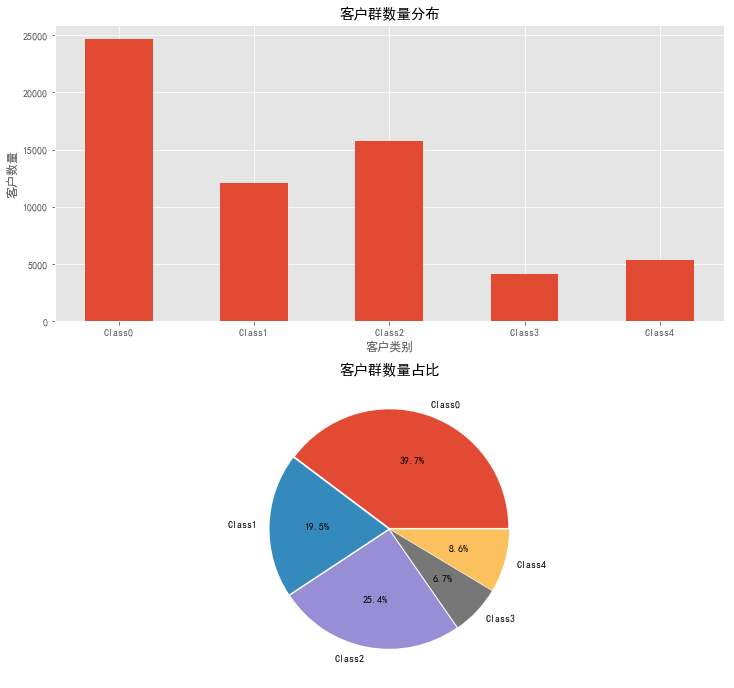

In [22]:
import matplotlib
import matplotlib.pyplot as plt
#s1:设置中文显示及绘图风格
matplotlib.rcParams['font.family'] =  'SimHei'
matplotlib.rcParams['font.sans-serif'] = ['SimHei'] 
matplotlib.rcParams['axes.unicode_minus'] = False  # 设置正常显示负号

##s2:数据与标签
dataCount = dataResult['SampleSize']
labels = dataResult['Category']
dataLenth = len(labels)
print(dataCount)
print(labels)

fig = plt.figure(figsize=(12,12))
#子图1 柱形图
ax1 = fig.add_subplot(2,1,1)
plt.bar(range(dataLenth),dataCount,width=0.5)
plt.xlabel("客户类别")
plt.ylabel("客户数量")
plt.xticks(range(dataLenth),labels)
plt.title("客户群数量分布")

#子图2 饼图
ax2 = fig.add_subplot(2,1,2)
explode = [0.01]*dataLenth
plt.pie(dataCount,explode,labels=labels,autopct="%1.1f%%")
plt.title("客户群数量占比")

#保存并显示
plt.show()

**C0:一般客户  C1:低价值客户  C2:重要挽留客户  C3:重要发展客户  C4:重要保持客户**  
◆ 重要保持客户、重要发展客户占比15.3%，不足两成，整体较少   
◆ 一般客户、低价值客户占比59.3%，接近六成，整体偏多  
◆ 重要挽留客户占比25.4%，接近四分之一，整体发挥空间大   
按照20/80法则：一般而言企业的80%收入由头部20%的用户贡献了企业收入的绝大部分，企业也需要投入资源服务好这部分客户。

同时，重要保持客户、重要发展客户、重要挽留客户这三类客户其实也对应着客户生命周期中的发展期、稳定器、衰退期三个时期。从客户生命周期的角度讲，也应重点投入资源召回衰退期的客户。


## 3.3 模型应用,应用聚类结果

数据分析最终的目的是针对分析结果提出并开展一系列的运营/营销策略，以期帮助企业发展。   
在本实例中，运营策略有三个方向：

★ 提高活跃度：提高一般客户、低价值客户的活跃度。将其转化为优质客户   
★ 提高留存率：与重要挽留客户互动，提高这部分用户的留存率 
★ 提高付费率：维系重要保持客户、重要发展客户的忠诚度，保持企业良好收入  

每个方向对应不同的策略，如会员升级、积分兑换、交叉销售、发放折扣券等手段：
1. 会员升级与保级(积分削减等)  
在会员升级或保级评价的时间点前，对接近但尚未达到要求的较高消费客户进行提醒或促销活动，提高客户满意度。
2. 首次兑换  
对接近但尚未达到标准的会员进行提醒或促销活动，提高客户满意度。
3. 交叉销售    
通过与非航空类企业的合作，使客户在其他消费过程中获得本公司积分，增强与公司联系，提高忠诚度

# 4 小结

+ 获取新客成本远大于维持老客，应努力维系客户关系水平，保持优质客户。
+ 差异化管理、精准营销，提高客户忠诚度、满意度，延长客户高水平消费。